In [1]:
import pandas as pd
import numpy as np
from scipy import stats as stats
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
import KeyFunctions as me
import skopt as skopt
import warnings

warnings.filterwarnings("ignore", message="The objective has been evaluated at this point before.")

RandState = 117
cv = 4

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(4, shuffle = True)

#Import Full Triclosan Dataset
df, labels = me.ConstructCombinedTriclosanDataset()

[train, test] = train_test_split(df, random_state = RandState, shuffle = True, train_size = 0.8)

y_tn = train.index
y_tt = test.index
X_tt = test.to_numpy()
X_tn = train.to_numpy()
display(labels)

['10-3', '10-4', '10-5', '10-7', '10-8', '10-9']

In [3]:
#Scale Dataset

from sklearn.preprocessing import StandardScaler

Scale = StandardScaler()

X_tn = Scale.fit_transform(X_tn)
X_tt = Scale.transform(X_tt)

In [4]:
#Calculate Cross Validation Scores
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate


df.columns = df.columns.astype(str)

RFC = RandomForestClassifier(random_state = RandState)

RFCscore = cross_val_score(RFC, X_tn, y_tn, cv = cv)
display("Random Forest Cross Validation")
display(RFCscore)
display(np.mean(RFCscore))

RFcv = cross_validate(RFC, X_tn, y_tn, cv = cv)
display(np.mean(RFcv['fit_time']))

'Random Forest Cross Validation'

array([0.6       , 0.9       , 0.6       , 0.77777778])

0.7194444444444444

0.12112033367156982

In [5]:
params = dict()
params['n_estimators'] = (10, 200, 'log-uniform')
params['max_features'] = (10, 900, 'log-uniform')
params['criterion'] = ['gini', 'entropy']

Bayes = skopt.BayesSearchCV(RFC, search_spaces = params, n_jobs = 4,
                      return_train_score = True, random_state = RandState, cv = cv)
RFBS = Bayes.fit(X_tn, y_tn)
RFC = RFBS.best_estimator_
SC_RFC = RFC.fit(X_tn, y_tn)

display(RFBS.best_params_)
display(RFBS.best_score_)
display(RFBS.cv_results_['std_test_score'][RFBS.best_index_])
display(RFBS.refit_time_)

OrderedDict([('criterion', 'entropy'),
             ('max_features', 60),
             ('n_estimators', 120)])

0.8222222222222223

0.08050764858994133

0.2300729751586914

In [6]:
from sklearn.metrics import confusion_matrix
y_pred = RFBS.predict(X_tt)

RFcounter = 0

for i in range(len(y_tt)):
    if y_pred[i] != y_tt[i]:
        display("Incorrect Prediction at " + str(i) + ", Predicted: "+ str(y_pred[i]) + "; Actual: " + str(y_tt[i]))
        RFcounter += 1
                
display("Total Predictions: " + str(i))
display("Total Errors: " + str(RFcounter))

CMNT = confusion_matrix(y_tt, y_pred, labels = labels)

'Incorrect Prediction at 2, Predicted: 10-5; Actual: 10-7'

'Total Predictions: 9'

'Total Errors: 1'

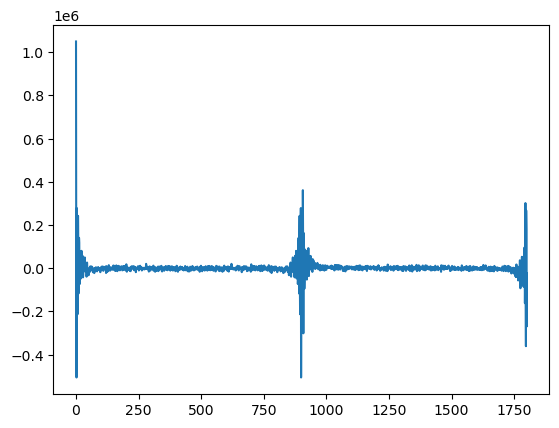

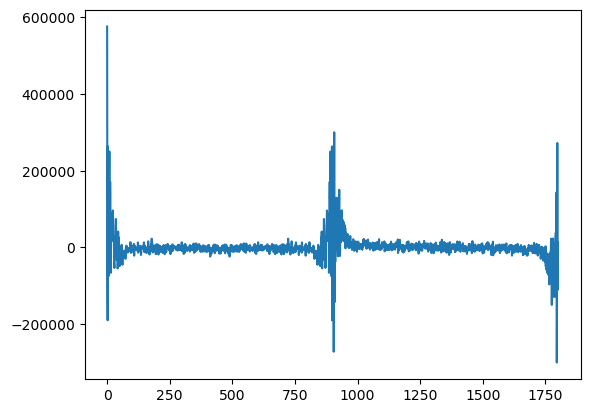

In [7]:
#Apply Fourier Transform to Training and Testing Data
#Fourier Transform Performs Best Without Scaling
X_tt = test.to_numpy()
X_tn = train.to_numpy()

X_tnf = np.fft.fft(X_tn)
X_ttf = np.fft.fft(X_tt)

#Data is stored as columns of all real values followed by columns of all imaginary values.
X_tnf = np.append(np.real(X_tnf), np.imag(X_tnf), axis = 1)
X_ttf = np.append(np.real(X_ttf), np.imag(X_ttf), axis = 1)


plt.figure()
plt.plot(X_tnf[1, :])
plt.figure()
plt.plot(X_tnf[7, :]);

In [8]:
#Calculate Cross Validation Scores
from sklearn.model_selection import cross_val_score

df.columns = df.columns.astype(str)

RFC = RandomForestClassifier(random_state = RandState)

RFCscore = cross_val_score(RFC, X_tnf, y_tn, cv = cv)
display("Random Forest Cross Validation")
display(RFCscore)
display(np.mean(RFCscore))

RFcv = cross_validate(RFC, X_tnf, y_tn, cv = cv)
display(np.mean(RFcv['fit_time']))

'Random Forest Cross Validation'

array([0.5       , 0.6       , 0.8       , 0.66666667])

0.6416666666666667

0.1227942705154419

In [9]:
params = dict()
params['n_estimators'] = (10, 200, 'log-uniform')
params['max_features'] = (10, 900, 'log-uniform')
params['criterion'] = ['gini', 'entropy']

Bayes = skopt.BayesSearchCV(RFC, search_spaces = params, n_jobs = 4,
                      return_train_score = True, random_state = RandState, cv = cv)
RFBS = Bayes.fit(X_tnf, y_tn)
RFC = RFBS.best_estimator_
FT_RFC = RFC.fit(X_tnf, y_tn)

display(RFBS.best_params_)
display(RFBS.best_score_)
display(RFBS.cv_results_['std_test_score'][RFBS.best_index_])
display(RFBS.refit_time_)

OrderedDict([('criterion', 'entropy'),
             ('max_features', 900),
             ('n_estimators', 78)])

0.8

0.2

0.8598611354827881

In [10]:
y_pred = RFBS.predict(X_ttf)

RFcounter = 0

for i in range(len(y_tt)):
    if y_pred[i] != y_tt[i]:
        display("Incorrect Prediction at " + str(i) + ", Predicted: "+ str(y_pred[i]) + "; Actual: " + str(y_tt[i]))
        RFcounter += 1
                
display("Total Predictions: " + str(i))
display("Total Errors: " + str(RFcounter))

CMFT = confusion_matrix(y_tt, y_pred, labels = labels)

'Incorrect Prediction at 2, Predicted: 10-5; Actual: 10-7'

'Total Predictions: 9'

'Total Errors: 1'

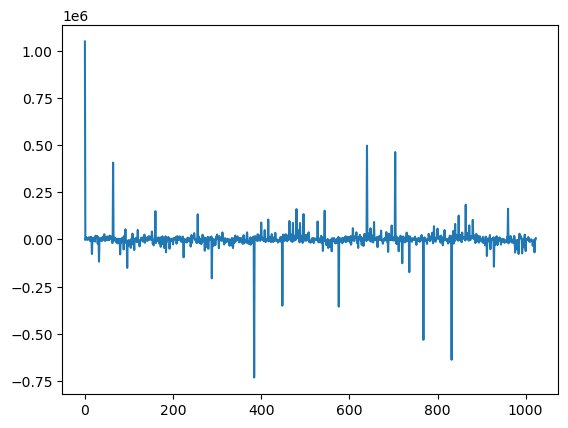

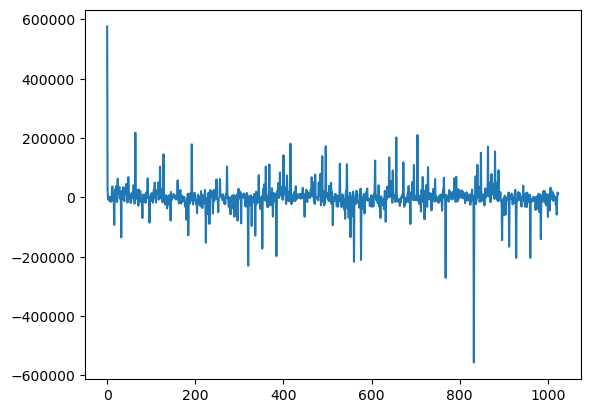

In [11]:
#Apply Welsh-Hadamard Transform to Training and Testing Data
from sympy.discrete.transforms import fwht, ifwht
X_tt = test.to_numpy()
X_tn = train.to_numpy()

Scale = StandardScaler()

X_tnh = np.apply_along_axis(fwht, axis=1, arr=X_tn)
X_tth = np.apply_along_axis(fwht, axis=1, arr=X_tt)

plt.figure()
plt.plot(X_tnh[1, :])
plt.figure()
plt.plot(X_tnh[7, :]);

In [12]:
#Calculate Cross Validation Scores
from sklearn.model_selection import cross_val_score

df.columns = df.columns.astype(str)

RFC = RandomForestClassifier(random_state = RandState)

RFCscore = cross_val_score(RFC, X_tnh, y_tn, cv = cv)
display("Random Forest Cross Validation")
display(RFCscore)
display(np.mean(RFCscore))

RFcv = cross_validate(RFC, X_tnh, y_tn, cv = cv)
display(np.mean(RFcv['fit_time']))

'Random Forest Cross Validation'

array([0.6       , 0.7       , 1.        , 0.88888889])

0.7972222222222222

0.18737369775772095

In [13]:
params = dict()
params['n_estimators'] = (10, 200, 'log-uniform')
params['max_features'] = (10, 900, 'log-uniform')
params['criterion'] = ['gini', 'entropy']

Bayes = skopt.BayesSearchCV(RFC, search_spaces = params, n_jobs = 4,
                      return_train_score = True, random_state = RandState, cv = cv)
RFBS = Bayes.fit(X_tnh, y_tn)
RFC = RFBS.best_estimator_
HT_RFC = RFC.fit(X_tnh, y_tn)

display(RFBS.best_params_)
display(RFBS.best_score_)
display(RFBS.cv_results_['std_test_score'][RFBS.best_index_])
display(RFBS.refit_time_)

OrderedDict([('criterion', 'gini'),
             ('max_features', 10),
             ('n_estimators', 57)])

0.8166666666666667

0.09574271077563383

0.15064358711242676

In [14]:
y_pred = RFBS.predict(X_tth)

RFcounter = 0

for i in range(len(y_tt)):
    if y_pred[i] != y_tt[i]:
        display("Incorrect Prediction at " + str(i) + ", Predicted: "+ str(y_pred[i]) + "; Actual: " + str(y_tt[i]))
        RFcounter += 1
                
display("Total Predictions: " + str(i))
display("Total Errors: " + str(RFcounter))

CMHT = confusion_matrix(y_tt, y_pred, labels = labels)

'Incorrect Prediction at 1, Predicted: 10-5; Actual: 10-7'

'Incorrect Prediction at 2, Predicted: 10-5; Actual: 10-7'

'Total Predictions: 9'

'Total Errors: 2'

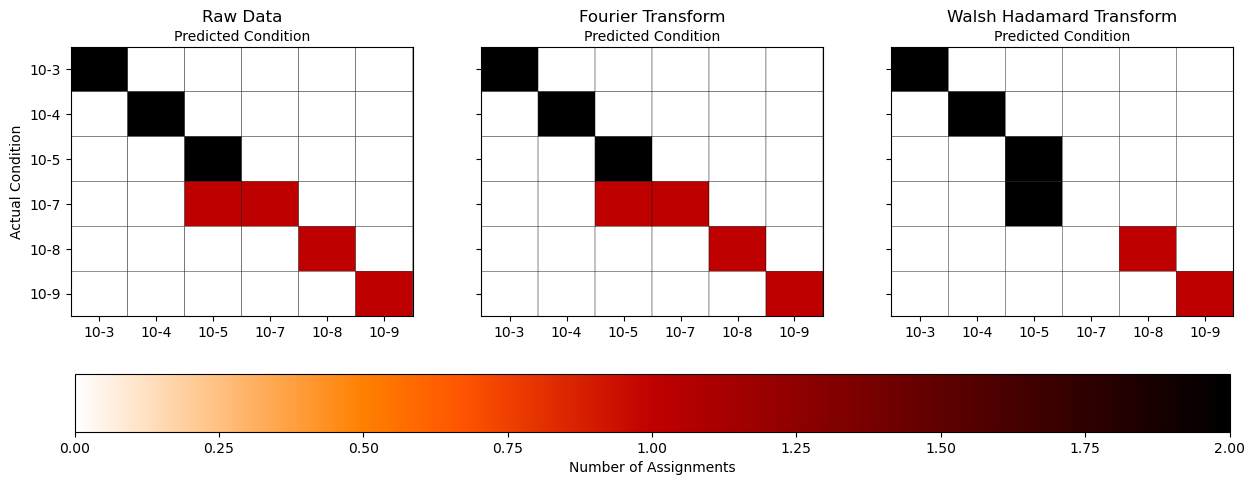

In [15]:

fig, axs = plt.subplots(1, 3, sharey = True, figsize = [15, 5])

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

pcm = axs[0].pcolor(CMNT, edgecolors = 'k', cmap = 'gist_heat_r')
plt.gca().invert_yaxis()
axs[0].set_xticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels)
axs[0].set_yticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels)
axs[0].set_ylabel("Actual Condition")
axs[0].set_xlabel("Predicted Condition")
axs[0].xaxis.set_label_position('top') 
axs[0].set_title('Raw Data');

axs[1].pcolor(CMFT, edgecolors = 'k', cmap = 'gist_heat_r');
plt.gca().invert_yaxis()
axs[1].set_xticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels)
axs[1].set_title('Fourier Transform');
axs[1].set_xlabel("Predicted Condition")
axs[1].xaxis.set_label_position('top')

axs[2].pcolor(CMHT, edgecolors = 'k', cmap = 'gist_heat_r')
plt.gca().invert_yaxis()
axs[2].set_xticks(ticks = np.linspace(0.5, len(labels)-0.5, num = len(labels)), labels = labels);
axs[2].set_title('Walsh Hadamard Transform');
axs[2].set_xlabel("Predicted Condition")
axs[2].xaxis.set_label_position('top')

fig.colorbar(pcm, ax = axs[:], location = 'bottom', label = 'Number of Assignments');

In [16]:
import glob

tcnp = pd.DataFrame()
for filename in glob.glob("Raman Data MITACs\\"+"ESMA"+"\\"+"tcnpowder"+"\\" + "Raw" + "\\*.txt"):
    ser = pd.read_csv(filename, delimiter = '\t', index_col = "#Wave")
    ser.drop("#Intensity", inplace = True, axis  = 1)
    ser = ser.transpose()
    tcnp = pd.concat([tcnp, ser], axis = 0)
tcnp.reset_index(inplace= True, drop = True)
    
tcnp_avg = tcnp.mean(axis = 0)

tcnp = tcnp_avg.iloc[:-163]
tcnp = tcnp.tolist()
tcnp_avg = [None]*43 + tcnp


C:\Users\jayapra1\Anaconda3\envs\Base\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 640x480 with 0 Axes>

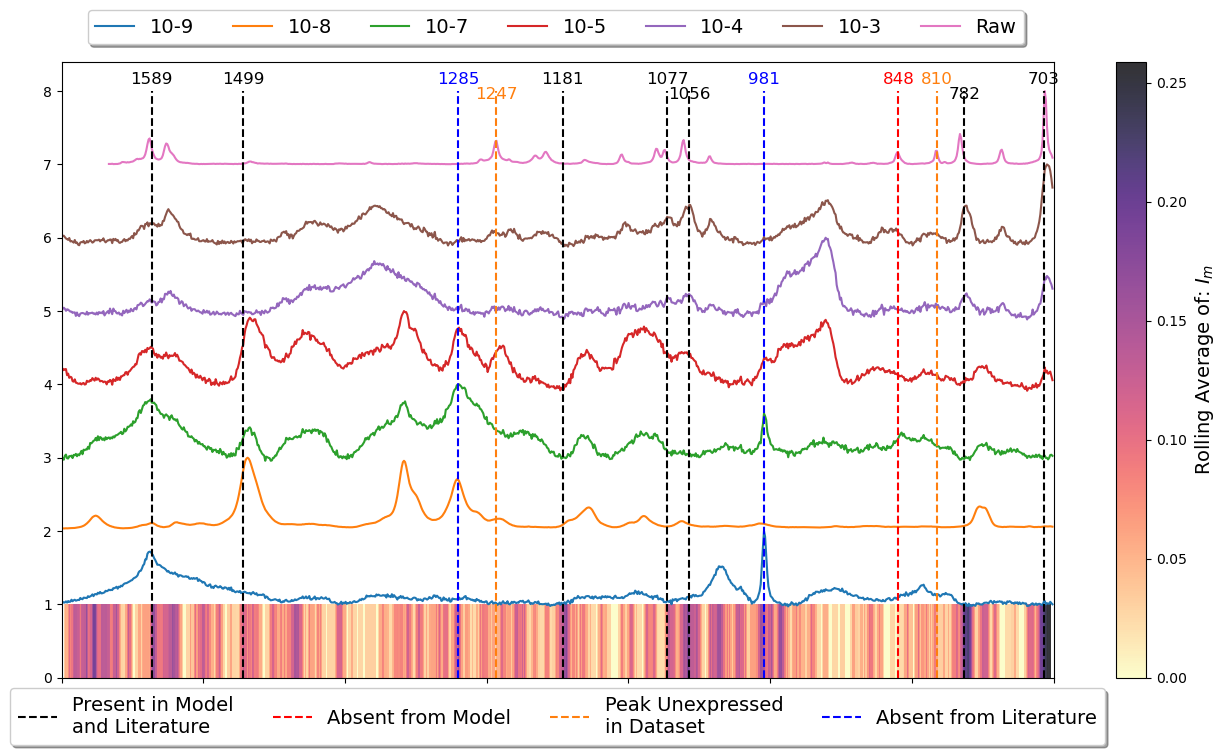

In [57]:
import matplotlib.colors as c
import matplotlib.ticker as mticker

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
plt.tight_layout()

fig = plt.figure(figsize = [16, 8]);
ax = plt.gca()
SC_imp = pd.Series(SC_RFC.feature_importances_)


#Calculate Average Spectra for Each Concentration
df_avg = pd.DataFrame(columns = df.columns)

concs = df.index.unique().tolist()
concs.sort(key = lambda x: int(x.split('-', 1)[-1]), reverse = True)
for ind in concs:
    df_avg.loc[ind, :] = df.loc[df.index[:] == ind].mean(axis = 0)

df_avg.loc["Raw"] = tcnp_avg
#Determine Maxima Based on First Spectra in Each Concnetration Level
mx_graph = 0
for ind, row in df_avg.iterrows():
        if max(row) > mx_graph:
            mx_graph = max(row)

#Scale Each First Spectra to [0,1] Based on Maxima
offset= 1 
for ind, row in df_avg.iterrows():
        row = row/np.nanmax(row) + offset
        ax.plot(row)
        offset += 1

        
ticks_loc = np.linspace(0, np.shape(df)[1], 8)
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ticklbls = np.linspace(max(df_avg.columns.astype(float)), min(df_avg.columns.astype(float)), 8)
ticklbls = np.round(ticklbls)
ax.set_xticklabels(ticklbls)

SC_imp.sort_values(ascending = False, inplace = True)
    
ax.legend(df_avg.index, loc = 8, ncol = len(df_avg.index))

X = SC_imp.index.values
Y = np.linspace(0, 1, 1)
Z = np.zeros((len(Y), len(X)))

SC_imp_raw = SC_imp.copy()
SC_imp = abs(1/np.log(SC_imp))
SC_imp = SC_imp.sort_index().rolling(5, center = True).mean()

for index, value in SC_imp.items():
    Z[:, index] = value
    
plt.pcolormesh(Z, cmap = 'magma_r', alpha = 0.8)
cb = plt.colorbar()
cb.set_label('Rolling Average of: ' + r'$I_m$', fontsize =14)

wavelbls = np.linspace(max(df_avg.columns.astype(float)), min(df_avg.columns.astype(float)), len(df.columns))
wavelbls = np.ndarray.astype(np.ndarray.astype(np.round(wavelbls), int), str)
islbls = SC_imp.round(3).astype(str)


anno1 = ax.vlines(892, ymin = 0, ymax = 8, color = 'k', linestyle = 'dashed')
ax.annotate(wavelbls[892], xy = (892, 8.1), fontsize = 'large', ha = 'center');

ax.vlines(820, ymin = 0, ymax = 8, color = 'k', linestyle = 'dashed')
ax.annotate(wavelbls[820], xy = (820, 7.9), fontsize = 'large', ha = 'center');

ax.vlines(570, ymin = 0, ymax = 8, color = 'k', linestyle = 'dashed')
ax.annotate(wavelbls[570], xy = (570, 7.9), fontsize = 'large', ha = 'center');

ax.vlines(550, ymin = 0, ymax = 8, color = 'k', linestyle = 'dashed')
ax.annotate(wavelbls[550], xy = (550, 8.1), fontsize = 'large', ha = 'center');

ax.vlines(455, ymin = 0, ymax = 8, color = 'k', linestyle = 'dashed')
ax.annotate(wavelbls[455], xy = (455, 8.1), fontsize = 'large', ha = 'center');

ax.vlines(165, ymin = 0, ymax = 8, color = 'k', linestyle = 'dashed');
ax.annotate(wavelbls[165], xy = (165, 8.1), fontsize = 'large', ha = 'center')

ax.vlines(82, ymin = 0, ymax = 8, color = 'k', linestyle = 'dashed')
ax.annotate(wavelbls[82], xy = (82, 8.1), fontsize = 'large', ha = 'center');


anno2 = ax.vlines(760, ymin = 0, ymax = 8, color = 'r', linestyle = 'dashed')
ax.annotate(wavelbls[760], xy = (760, 8.1), fontsize = 'large', color = 'r', ha = 'center');


anno3 = ax.vlines(395, ymin = 0, ymax = 8, color = 'tab:orange', linestyle = 'dashed')
ax.annotate(wavelbls[395], xy = (395, 7.9), fontsize = 'large', color = 'tab:orange', ha = 'center');

ax.vlines(795, ymin = 0, ymax = 8, color = 'tab:orange', linestyle = 'dashed')
ax.annotate(wavelbls[795], xy = (795, 8.1), fontsize = 'large', color = 'tab:orange', ha = 'center');




anno4 = ax.vlines(360, ymin = 0, ymax = 8, color = 'b', linestyle = 'dashed');
ax.annotate(wavelbls[360], xy = (360, 8.1), fontsize = 'large', color = 'b', ha = 'center');

ax.vlines(638, ymin = 0, ymax = 8, color = 'b', linestyle = 'dashed');
ax.annotate(wavelbls[638], xy = (638, 8.1), fontsize = 'large', color = 'b', ha = 'center');


anno_legend = plt.legend(handles = [anno1, anno2, anno3, anno4], loc=8, ncol= 4, bbox_to_anchor = (0.25, -.125, 0.5, 0.5), \
                         fontsize = 14, labels = ['Present in Model\nand Literature', 'Absent from Model',\
                                   'Peak Unexpressed\nin Dataset', 'Absent from Literature'], fancybox = True, shadow = True)
ax.legend(df_avg.index, bbox_to_anchor = (0.48, 0.6, 0.5, 0.5), ncol = len(df_avg.index)+3, fontsize = 14,\
                                    fancybox = True, shadow = True)
plt.gca().add_artist(anno_legend);

plt.savefig("G:/My Drive/MITACs/Finalized Code and Data/Tables and Figures/SVG Files/Tri Peak Identification.svg", format = "svg", bbox_inches='tight');
plt.savefig("G:/My Drive/MITACs/Finalized Code and Data/Tables and Figures/PNG Files/Tri Peak Identification.png", format = "png", bbox_inches='tight');


In [55]:
x = 638
display(SC_imp[x-5:x+5])
display(SC_imp_raw.sort_index()[x-5:x+5])

633    0.119201
634    0.156933
635    0.158138
636    0.150226
637    0.150226
638    0.142180
639    0.104448
640    0.097366
641    0.094116
642    0.127430
dtype: float64

633    0.008754
634    0.000000
635    0.010540
636    0.004989
637    0.002918
638    0.002934
639    0.000000
640    0.003798
641    0.000000
642    0.000638
dtype: float64